In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools
import warnings
from library import *
warnings.simplefilter("ignore")

In [2]:
df = pd.read_csv('newark_flights.csv')
df.columns

Index(['Unnamed: 0', 'YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE',
       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')

In [3]:
# Clean up null

df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop(df[(df['ORIGIN_AIRPORT']=='EWR') & (df['DEPARTURE_TIME'].isna())].index, inplace=True)
df.drop(df[(df['DESTINATION_AIRPORT']=='EWR') & (df['ARRIVAL_TIME'].isna())].index, inplace=True)
df.drop(df[(df['ARRIVAL_DELAY'].isna())].index, inplace=True)
delay = list(df[df.columns[-6:]].columns)
for cols in delay:
    if df[cols].isna().any():
        df[cols].fillna(value=0, inplace=True)

In [4]:
# df.isna().sum()

In [5]:
# Clean up date format
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

# Clean up Arrival time format
df["HOUR"] = df["SCHEDULED_ARRIVAL"].apply(lambda x: int(str(int(x))[0:2]) if len(str(int(x)))==4 else int(str(int(x))[0:1]))
df["MINUTE"]  = df["SCHEDULED_ARRIVAL"].apply(lambda x: int(str(int(x))[-2:]))
df["SCHEDULED_ARRIVAL"] = pd.to_datetime(df[['YEAR','MONTH', 'DAY', 'HOUR', 'MINUTE']])
df["SCH_ARR_TEMP"] = pd.to_datetime(df[['YEAR','MONTH', 'DAY', 'HOUR']])

# Clean up Departure time format
df["HOUR"] = df["SCHEDULED_DEPARTURE"].apply(lambda x: int(str(int(x))[0:2]) if len(str(int(x)))==4 else int(str(int(x))[0:1]))
df["MINUTE"]  = df["SCHEDULED_DEPARTURE"].apply(lambda x: int(str(int(x))[-2:]))
df["SCHEDULED_DEPARTURE"] = pd.to_datetime(df[['YEAR','MONTH', 'DAY', 'HOUR', 'MINUTE']])
df["SCH_DEP_TEMP"] = pd.to_datetime(df[['YEAR','MONTH', 'DAY', 'HOUR']])

# Temporary column for Darksky data mapping
df["NYC_TIME_TEMP"] = df.apply(lambda row: row['SCH_ARR_TEMP'] if row['DESTINATION_AIRPORT'] == 'EWR' else row['SCH_DEP_TEMP'], axis=1)

# Combine United Express (EV) as mainline United (UA)
df['AIRLINE'] = df.apply(lambda row: 'UA' if row['AIRLINE'] == 'EV' else row['AIRLINE'], axis=1)

# Simplify delay reason columns - for EDA only, not as predictors
df['DELAY_REASON'] = df.apply(lambda row: 'Air system' if row['AIR_SYSTEM_DELAY'] == 1 else 
                              ('Security' if row['SECURITY_DELAY'] == 1 else 
                               ('Airline' if row['AIRLINE_DELAY'] == 1 else 
                                ('Late aircraft' if row['LATE_AIRCRAFT_DELAY'] == 1 else 
                                 ('Weather' if row['WEATHER_DELAY'] == 1 else 0)))), axis=1)
    
# Dummy variables for Arrival or Departure
df['DEPARTURE'] = df.apply(lambda row: 0 if row['DESTINATION_AIRPORT'] == 'EWR' else 1, axis=1)

# Time in reference to Newark only
df['SCHEDULED_TIME'] = df.apply(lambda row: row['SCHEDULED_DEPARTURE'] if row['DEPARTURE'] == 1 else row['SCHEDULED_ARRIVAL'], axis=1)

# Time in reference to Newark only - Hour
df['SCHEDULED_HOUR'] = df['SCHEDULED_TIME'].apply(lambda row: row.hour)

# Dummy variables for target (Delay)
df['DELAY'] = df.apply(lambda row: 1 if (row['DEPARTURE']==1)&(row['DEPARTURE_DELAY']>15) else (1 if (row['DEPARTURE']==0)&(row['ARRIVAL_DELAY']>15) else 0), axis=1)

In [6]:
# Retain only relevant columns

keep_columns = ['DATE', 'DAY_OF_WEEK', 'SCHEDULED_HOUR', 'DEPARTURE', 'AIRLINE',
                'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DISTANCE', 'DELAY', 'DELAY_REASON']
temp_columns = ['NYC_TIME_TEMP', 'TAIL_NUMBER'] # temporary for mapping only
df = df[keep_columns + temp_columns]

In [7]:
# Import and clean DarkSky weather database
# See separate notbook: dark_sky.ipynb for details on data extraction

weather = pd.DataFrame(pd.read_csv('newark_weather.csv')) # saved output from DarkSky
weather.drop('Unnamed: 0', axis=1, inplace=True)
weather['temperature'] = weather['temperature'].apply(lambda row: round(row,1))
weather['nyc_time'] = pd.to_datetime(weather['nyc_time'])
weather = weather.rename(columns={'icon':'weather'})
weather = weather.set_index('nyc_time')
weather = weather[weather.columns[:-4]]
weather.head()

,weather,precipIntensity,temperature,windSpeed,visibility
nyc_time,,,,,
2015-01-01 00:00:00,clear,0.0,-4.4,1.66,9.997
2015-01-01 01:00:00,clear,0.0,-4.4,1.91,9.997
2015-01-01 02:00:00,clear,0.0,-4.4,2.38,9.997
2015-01-01 03:00:00,clear,0.0,-5.0,1.85,9.997
2015-01-01 04:00:00,clear,0.0,-4.4,2.77,9.997


In [8]:
# Join main data with DarkSky weather database

df = df.join(weather, on='NYC_TIME_TEMP')
df.drop('NYC_TIME_TEMP', axis=1, inplace=True)

In [9]:
# Import plane registration database from FAA
# See separate notbook: plane_registration.ipynb for details on data extraction

plane_reg = pd.DataFrame(pd.read_csv('newark_plane_reg.csv'))
plane_reg.drop('Unnamed: 0', axis=1, inplace=True)
plane_reg = plane_reg.set_index('N-Number')
plane_reg.head()

,Registered
N-Number,
N438WN,2003-07-21
N68061,2002-03-08
N914UY,2014-11-07
N446UA,1998-07-02
N18120,2005-02-25


In [10]:
# Join main data with plane registration database from FAA

df = df.join(plane_reg, on='TAIL_NUMBER')
df.drop(df[(df['Registered'].isna())].index, inplace=True)
df.drop('TAIL_NUMBER', axis=1, inplace=True)

df['planeAge'] = df['DATE'] - pd.to_datetime(df['Registered'])
df['planeAge'] = df['planeAge'].apply(lambda row: row.total_seconds()/365/24/60/60 if row.total_seconds() > 0 else 0)
df.drop('Registered', axis=1, inplace=True)
df = df.dropna()
df.head()

,DATE,DAY_OF_WEEK,SCHEDULED_HOUR,DEPARTURE,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,DELAY,DELAY_REASON,weather,precipIntensity,temperature,windSpeed,visibility,planeAge
0,2015-01-01,4,5,0,UA,SJU,EWR,1608,0,0,clear,0.0,-4.4,0.00,9.997,4.961644
1,2015-01-01,4,5,0,B6,SJU,EWR,1608,0,0,clear,0.0,-4.4,0.00,9.997,10.147945
2,2015-01-01,4,5,0,UA,BQN,EWR,1585,0,0,clear,0.0,-4.4,0.00,9.997,9.495890
3,2015-01-01,4,7,0,UA,JAX,EWR,820,0,0,clear,0.0,-5.6,1.46,9.997,11.200000
4,2015-01-01,4,7,0,UA,CHS,EWR,628,0,0,clear,0.0,-5.6,1.46,9.997,13.706849


In [11]:
# Assign df0 for all columns for analysis and visualization

df0 = df.copy()

# Create dummy variables for categorical columns:

df['United'] = df.apply(lambda row: 1 if row['AIRLINE'] == 'UA' else 0, axis=1)
df = pd.get_dummies(df, prefix=['weather','Day','Hour'], columns=['weather', 'DAY_OF_WEEK','SCHEDULED_HOUR'])

# Remove dummy columns to avoid multicollinearity

dummy_drop = ['weather_clear', 'weather_partly-cloudy',
              'Day_4',
              'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4']
df.drop(dummy_drop, axis=1, inplace=True)

# Assign df using only columns relevant to modelling

drop_list = ['DATE', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
             'DELAY_REASON', 'visibility', 'precipIntensity']
df.drop(drop_list, axis=1, inplace=True)

In [12]:
# for col in df.columns:
#     print(col, '\n', df[col].value_counts(), '\n\n')

In [13]:
print('List of predictors and target to be fed into model')
display(df.dtypes)
display(df.shape)

List of predictors and target to be fed into model


DEPARTURE           int64
DISTANCE            int64
DELAY               int64
temperature       float64
windSpeed         float64
planeAge          float64
United              int64
weather_cloudy      uint8
weather_fog         uint8
weather_rain        uint8
weather_sleet       uint8
weather_snow        uint8
Day_1               uint8
Day_2               uint8
Day_3               uint8
Day_5               uint8
Day_6               uint8
Day_7               uint8
Hour_5              uint8
Hour_6              uint8
Hour_7              uint8
Hour_8              uint8
Hour_9              uint8
Hour_10             uint8
Hour_11             uint8
Hour_12             uint8
Hour_13             uint8
Hour_14             uint8
Hour_15             uint8
Hour_16             uint8
Hour_17             uint8
Hour_18             uint8
Hour_19             uint8
Hour_20             uint8
Hour_21             uint8
Hour_22             uint8
Hour_23             uint8
dtype: object

(185142, 37)

### Target and candidates for predictors
**Target** = Delay [0/1]

**Predictors Category 1 : Airport/Airline**
1. Departure [0/1] - departure or arrival at Newark
2. Distance - flight path in miles
3. Plane age - in years
4. United [0/1] - United Airlines or competitors

**Predictors Category 2 : Weather measurements**
5. Wind speed
6. Temperature

**Predictors Category 3 : Weather & time as categorical variables:**
7. Type of weather (5 types) - rain, snow, sleet, fog, cloudy [0/1]
8. Day of the week (6 days) [0/1]
9. Hour of the day (20 hours) [0/1]

# EDA

In [14]:
# Subset delayed vs ontime flights

dfdelay1 = df0[df0['DELAY']==1]
dfdelay0 = df0[df0['DELAY']==0]
df0.columns

Index(['DATE', 'DAY_OF_WEEK', 'SCHEDULED_HOUR', 'DEPARTURE', 'AIRLINE',
       'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DISTANCE', 'DELAY',
       'DELAY_REASON', 'weather', 'precipIntensity', 'temperature',
       'windSpeed', 'visibility', 'planeAge'],
      dtype='object')

In [15]:
# features = ['SCHEDULED_HOUR', 'DAY_OF_WEEK', 'planeAge', 'DEPARTURE']
# f, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
# for n, feature in enumerate(features):
#     ax = ax{n}
#     sns.distplot(dfdelay1[[features[n]]], hist=False, rug=True, label='Delayed', ax=ax)
#     sns.distplot(dfdelay0[[features[n]]], hist=False, rug=True, label='Not delayed', ax=ax)
#     ax.set_xlabel(features[n])
# plt.show()

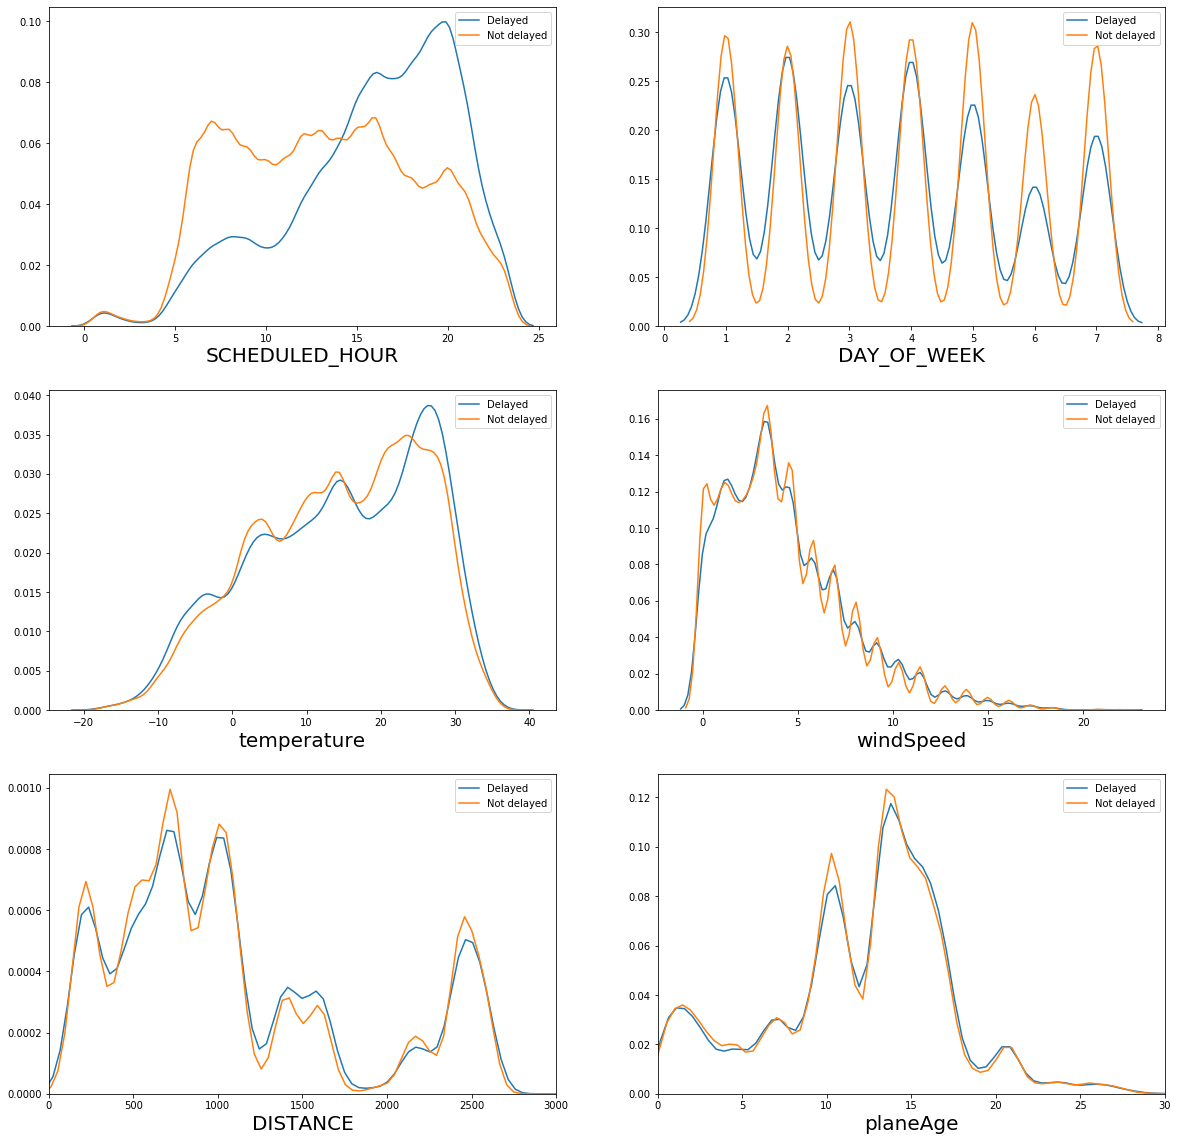

In [16]:
feature = ['SCHEDULED_HOUR','DAY_OF_WEEK','temperature',
           'windSpeed','DISTANCE','planeAge']
f, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
sns.distplot(dfdelay1[[feature[0]]], hist=False, label='Delayed', ax=ax0)
sns.distplot(dfdelay0[[feature[0]]], hist=False, label='Not delayed', ax=ax0)
sns.distplot(dfdelay1[[feature[1]]], hist=False, label='Delayed', ax=ax1)
sns.distplot(dfdelay0[[feature[1]]], hist=False, label='Not delayed', ax=ax1)
sns.distplot(dfdelay1[[feature[2]]], hist=False, label='Delayed', ax=ax2)
sns.distplot(dfdelay0[[feature[2]]], hist=False, label='Not delayed', ax=ax2)
sns.distplot(dfdelay1[[feature[3]]], hist=False, label='Delayed', ax=ax3)
sns.distplot(dfdelay0[[feature[3]]], hist=False, label='Not delayed', ax=ax3)
sns.distplot(dfdelay1[[feature[4]]], hist=False, label='Delayed', ax=ax4)
sns.distplot(dfdelay0[[feature[4]]], hist=False, label='Not delayed', ax=ax4)
sns.distplot(dfdelay1[[feature[5]]], hist=False, label='Delayed', ax=ax5)
sns.distplot(dfdelay0[[feature[5]]], hist=False, label='Not delayed', ax=ax5)
ax0.set_xlabel(feature[0],fontsize=20)
ax1.set_xlabel(feature[1],fontsize=20)
ax2.set_xlabel(feature[2],fontsize=20)
ax3.set_xlabel(feature[3],fontsize=20)
ax4.set_xlabel(feature[4],fontsize=20)
ax5.set_xlabel(feature[5],fontsize=20)
ax4.set_xlim(0,3000)
ax5.set_xlim(0,30)
plt.show()

In [17]:
# Check statistical impact of weather condition on delay

from scipy.stats import chisquare

test_table1 = (pd.pivot_table(df, values='Day_1', index=['DELAY'], columns=['weather_snow'],
                              aggfunc=len).unstack('DELAY').values).reshape(-2,2).T

test_table2 = (pd.pivot_table(df, values='Day_1', index=['DELAY'], columns=['weather_fog'],
                              aggfunc=len).unstack('DELAY').values).reshape(-2,2).T

test_table3 = (pd.pivot_table(df, values='Day_1', index=['DELAY'], columns=['United'],
                              aggfunc=len).unstack('DELAY').values).reshape(-2,2).T

test_table4 = (pd.pivot_table(df, values='Day_1', index=['DELAY'], columns=['DEPARTURE'],
                              aggfunc=len).unstack('DELAY').values).reshape(-2,2).T

display('Chi-test: Does SNOW impact flight punctuality?')
display(test_table1, f'p-value = {chisquare(test_table1)[1][0]}')

display('Chi-test: Does FOG impact flight punctuality?')
display(test_table2, f'p-value = {chisquare(test_table2)[1][0]}')

display('Chi-test: Is UNITED Airlines worse than others on flight punctuality?')
display(test_table3, f'p-value = {chisquare(test_table3)[1][0]}')

display('Chi-test: Are DEPARTURE flights more likely to be delayed?')
display(test_table4, f'p-value = {chisquare(test_table4)[1][0]}')

'Chi-test: Does SNOW impact flight punctuality?'

array([[143335,    320],
       [ 41197,    290]])

'p-value = 0.0'

'Chi-test: Does FOG impact flight punctuality?'

array([[141492,   2163],
       [ 40424,   1063]])

'p-value = 0.0'

'Chi-test: Is UNITED Airlines worse than others on flight punctuality?'

array([[ 35763, 107892],
       [  8893,  32594]])

'p-value = 0.0'

'Chi-test: Are DEPARTURE flights more likely to be delayed?'

array([[72556, 71099],
       [19939, 21548]])

'p-value = 0.0'

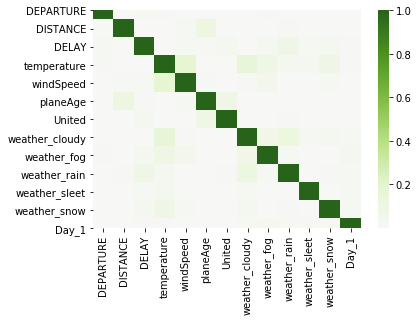

In [18]:
# Double check there is no strong collinearity between predictors

dfcorr = df.iloc[:,:13] # exclude dummy variable for days and hours
sns.heatmap(abs(dfcorr.corr()), cmap="PiYG", center=0)
plt.show()

# Modelling

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE

In [20]:
# Split target and predictors

y = df['DELAY']
X = df.drop('DELAY', axis=1)

# Split train and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Due to class imbance between delayed and not delayed, use SMOTE:

smote = SMOTE()
X_train, y_train = smote.fit_sample(X_train, y_train) 

In [21]:
# Automate Confusion Matrix

# Save result of each confusion matrix to be compared between different models later
def cf_measures(y, y_pred):
    cf_matrix = confusion_matrix(y, y_pred)
    TN, FP, FN, TP = cf_matrix[0][0], cf_matrix[0][1], cf_matrix[1][0], cf_matrix[1][1]
    TPR = round(TP/(TP+FN),5) # Power
    FPR = round(FP/(FP+TN),5) # Alpha
    FNR = round(FN/(FN+TP),5) # Beta
    TNR = round(TN/(TN+FN),5)
    Acc = round((TP+TN)/np.sum(cf_matrix),5)
    Pre = round(TP/(TP+FP),5)
    return TPR, FPR, FNR, TNR, Acc, Pre

# Plot confusion matrix and display summary
def cf_matrix(y, y_pred):
    cf_matrix = confusion_matrix(y, y_pred)
    plt.imshow(cf_matrix,  cmap=plt.cm.Blues)
    thresh = cf_matrix.max() / 2.  
    for i, j in itertools.product(range(cf_matrix.shape[0]), range(cf_matrix.shape[1])):
            plt.text(j, i, cf_matrix[i, j],
                     horizontalalignment='center', fontsize=12,
                     color='white' if cf_matrix[i, j] > thresh else 'black')
    plt.ylabel('True Delay')
    plt.xlabel('Predicted Dela')
    plt.xticks([0,1])
    
    TPR, FPR, FNR, TNR, Acc, Pre = cf_measures(y, y_pred)
    print(f'FalsePos={round(FPR*100,2)}%, FalseNeg={round(FNR*100,2)}%')
    print(f'TruePos={round(TPR*100,2)}%, TrueNeg={round(TNR*100,2)}%')
    print(f'Accuracy={round(Acc*100,2)}%, Precision={round(Pre*100,2)}%')

FalsePos=8.71%, FalseNeg=29.04%
TruePos=70.96%, TrueNeg=75.87%
Accuracy=81.13%, Precision=89.07%


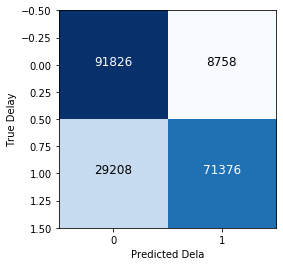

In [22]:
# Baseline: Logistic regression

baseline = Pipeline([('ssc', StandardScaler()),
                    ('logreg', LogisticRegression())])
baseline.fit(X_train, y_train)
y_pred_train = baseline.predict(X_train)
baseline_measures = cf_measures(y_train, y_pred_train)
cf_matrix(y_train, y_pred_train)

In [23]:
# # SVC (kernel=Linear)
# svc1 = Pipeline([('ssc', StandardScaler()),
#                  ('pca', PCA(n_components=1)),
#                  ('svc', LinearSVC())])
# svc1.fit(X_train, y_train)
# round(svc1.score(X_train, y_train),4)

FalsePos=17.63%, FalseNeg=16.82%
TruePos=83.18%, TrueNeg=83.04%
Accuracy=82.78%, Precision=82.51%


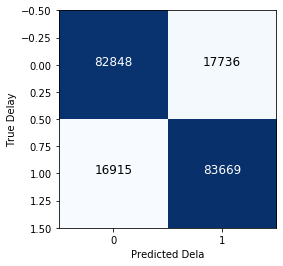

In [24]:
# Decision Tree

dtree1 = Pipeline([('ssc', StandardScaler()),
                  ('pca', PCA(n_components=15)),
                  ('tree', DecisionTreeClassifier(random_state=123))])
dtree1.fit(X_train, y_train)
y_pred_train = dtree1.predict(X_train)
dtree1_measures = cf_measures(y_train, y_pred_train)
cf_matrix(y_train, y_pred_train)

k=10, 0.33742509257419323
k=35, 0.9949391556537762


[0.03854596 0.0362977  0.03476517 0.0343499  0.03360993 0.03286385
 0.03237395 0.03186875 0.03179611 0.03095378]


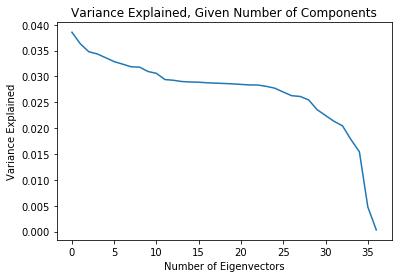

In [25]:
# Explore PCA

df_TF = StandardScaler().fit_transform(df)
fit = PCA()
pca = fit.fit_transform(df_TF)
k=10

plt.plot(fit.explained_variance_ratio_)
plt.title("Variance Explained, Given Number of Components")
plt.xlabel("Number of Eigenvectors")
plt.ylabel("Variance Explained")

print(f'k={k}, {fit.explained_variance_ratio_[:k].sum()}')
print(f'k={35}, {fit.explained_variance_ratio_[:35].sum()}')
print('\n')
print(fit.explained_variance_ratio_[:k])

# To do list

1. Predict proba
2. Threshold selection, Metz's m, cost of error
3. ROC and AUC
4. Optimize parameter for each model
5. Try RFE - Wrapper method etc
6. Clustering?
7. If need to choose, choose to reduce False Negative  
    coz don't want airline to think that there's no delay when there is one
